In [1]:
import wandb
from wandb.keras import WandbCallback

2023-06-20 19:56:35.288293: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 19:56:36.114846: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPooling2D, Input, concatenate, Conv2D, Activation, ZeroPadding2D, UpSampling2D, add
from tensorflow.keras.models import *
from qkeras import *

#import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import load_img

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from tqdm import tqdm

In [4]:
PRETRAINED = True
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


2023-06-20 19:56:37.855310: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-20 19:56:37.855369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: cmsgpu01.hep.wisc.edu
2023-06-20 19:56:37.855382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: cmsgpu01.hep.wisc.edu
2023-06-20 19:56:37.855470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.30.2
2023-06-20 19:56:37.855518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.30.2
2023-06-20 19:56:37.855527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 530.30.2


In [5]:
def iou_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, [1, 2, 3]) + K.sum(y_pred, [1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


# jaccard similarity: the size of the intersection divided by the size of the union of two sets
def jaccard_index(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [6]:
#TODO: Data generation
BASE_PATH = "/nfs_scratch/hsharma/MachineLearning/ClusterFinder/data/images/"
IMG_PATH = 'input/'
ANNOTATION_PATH = 'trimaps/'
num = 10000

input_img_paths = sorted(
    [
        os.path.join(BASE_PATH, IMG_PATH, fname)
        for fname in os.listdir(BASE_PATH+IMG_PATH)
        if fname.endswith(".png") and "(" not in fname
    ]
)[:num]


annotation_img_paths = []

for fname in tqdm(input_img_paths[:num]):
    annp = os.path.join(BASE_PATH, ANNOTATION_PATH, fname.split("/")[-1].replace("img", "annm"))
    if os.path.isfile(annp):
        annotation_img_paths.append(annp)
        input_img_paths.append(fname)
    else:
        pass

input_img_paths = input_img_paths[num:]
len(input_img_paths), len(annotation_img_paths)

100%|██████████| 10000/10000 [00:01<00:00, 5935.71it/s]


(10000, 10000)

In [7]:
[x for x in input_img_paths if "(" in x]

[]

In [8]:
input_img_paths[0], annotation_img_paths[0]

('/nfs_scratch/hsharma/MachineLearning/ClusterFinder/data/images/input/ECAL_img_0.png',
 '/nfs_scratch/hsharma/MachineLearning/ClusterFinder/data/images/trimaps/ECAL_annm_0.png')

[3580 6733 1473 6141]


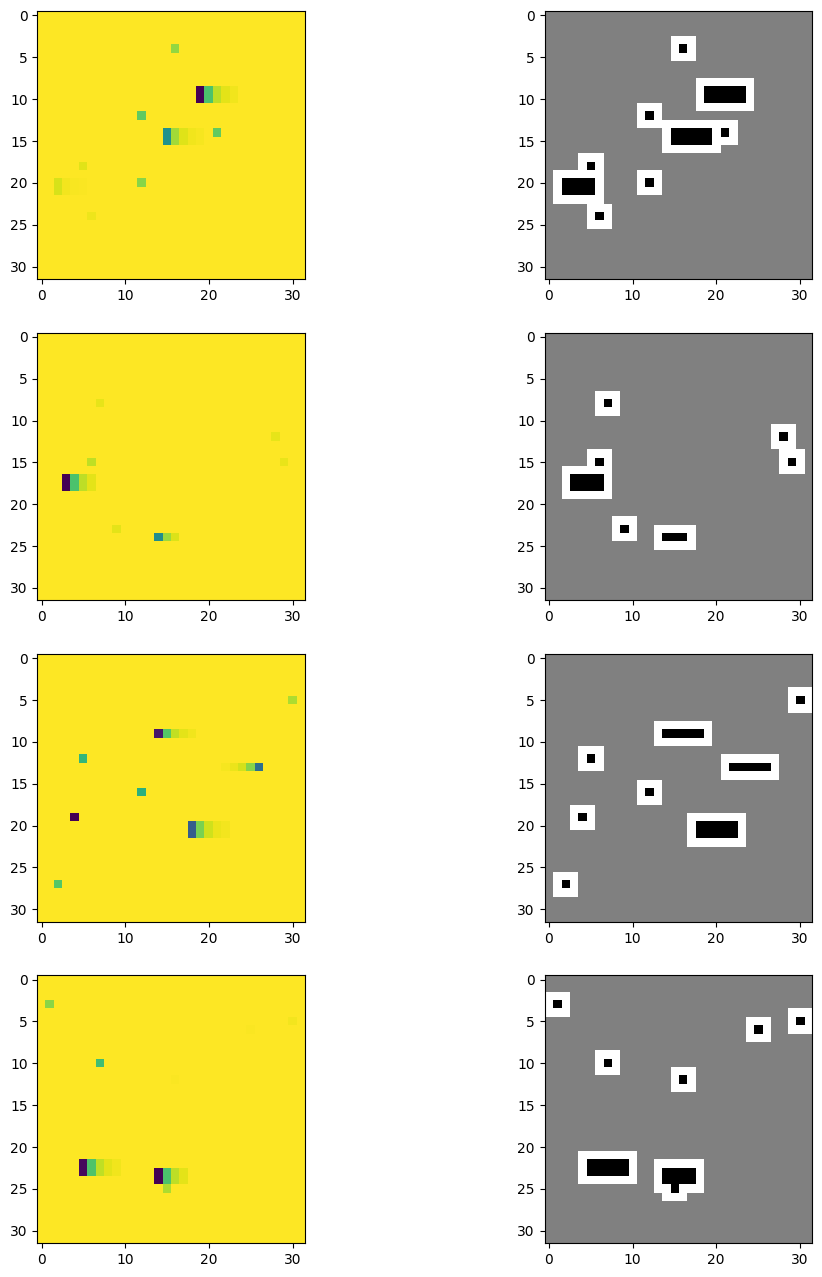

In [9]:
num_example_to_display = 4

sample_idxs = np.random.randint(0, len(input_img_paths)-1, size=(num_example_to_display,))
#sample_idxs = [0, 1, 2, 3]
print(sample_idxs)

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=2, figsize=(12,4*num_example_to_display))

for i, sample_idx in enumerate(sample_idxs):
  img = Image.open(input_img_paths[sample_idx]) 
  mask = Image.open(annotation_img_paths[sample_idx])
  #img = Image.fromarray(np.array(img))
  axs[i][0].imshow(img)
  axs[i][1].imshow(mask, cmap='gray')

In [10]:
IMG_SHAPE = 32

def normalize(image, mask):
    image = tf.cast(image, tf.float32) / 255.0
    mask -= 1
    return image, mask

def load_and_preprocess(img_filepath, mask_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SHAPE, IMG_SHAPE])

    mask = tf.io.read_file(mask_filepath)
    mask = tf.io.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_SHAPE, IMG_SHAPE])

    img, mask = normalize(img, mask)

    return img, mask

In [11]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

input_img_paths, annotation_img_paths = shuffle(input_img_paths, annotation_img_paths, random_state=42)
input_img_paths_train, annotation_img_paths_train = input_img_paths[: -1200], annotation_img_paths[: -1200]
input_img_paths_test, annotation_img_paths_test = input_img_paths[-1200:-800], annotation_img_paths[-1200:-800]

trainloader = tf.data.Dataset.from_tensor_slices((input_img_paths_train, annotation_img_paths_train))
testloader = tf.data.Dataset.from_tensor_slices((input_img_paths_test, annotation_img_paths_test))

trainloader = (
    trainloader
    .shuffle(1024)
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = (
    testloader
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [12]:
input_img_paths_test, annotation_img_paths_test = input_img_paths[-800:], annotation_img_paths[-800:]
maintestloader = tf.data.Dataset.from_tensor_slices((input_img_paths_test, annotation_img_paths_test))

maintestloader = (
    maintestloader
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

2023-06-20 19:56:43.317944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [8800]
	 [[{{node Placeholder/_1}}]]
2023-06-20 19:56:43.318596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8800]
	 [[{{node Placeholder/_0}}]]


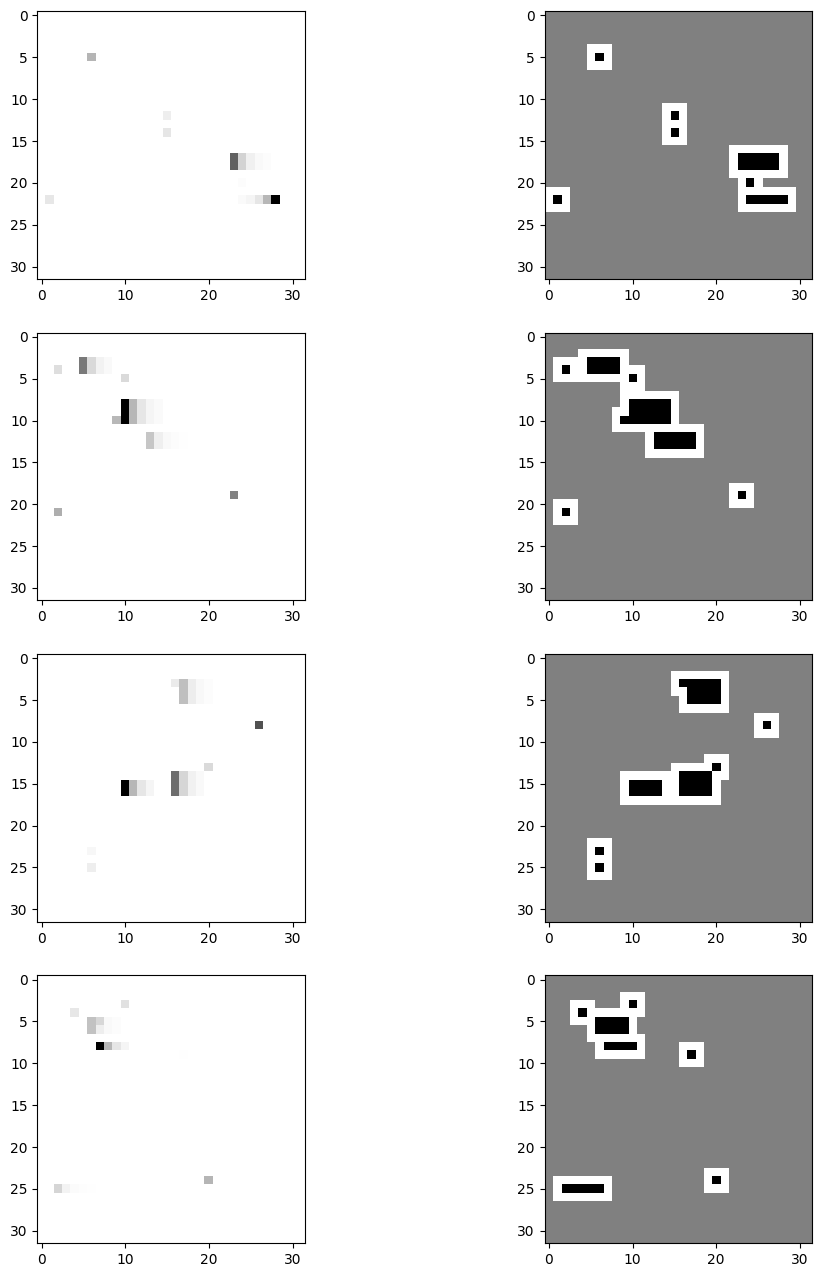

In [13]:
num_example_to_display = 4

img, mask = next(iter(trainloader))

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=2, figsize=(12,4*num_example_to_display))

for i in range(num_example_to_display):
  axs[i][0].imshow(img[i]);
  axs[i][1].imshow(np.squeeze(mask[i],-1), cmap='gray');

In [14]:
mask[0].shape

TensorShape([32, 32, 1])

### Modeling

In [15]:
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [16]:
OUTPUT_CHANNEL = 3

class UNETLiteV4Model:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        inputs = Input(input_size)

        conv1, pool1 = self.__ConvBlock(4, (3,3), (2,2), 'relu', 'same', inputs) 
        conv2, up3 = self.__UpConvBlock(8, 4, (3,3), (2,2), (2,2), 'relu', 'same', pool1, conv1)

        conv4 = self.__ConvBlock(4, (3,3), (2,2), 'relu', 'same', up3, False)

        outputs = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(conv4)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
            pool = MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = concatenate([up, shared_layer], axis=3)

        return conv, up

In [17]:
class UNETLiteV3Model:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        inputs = Input(input_size)

        conv1, pool1 = self.__ConvBlock(4, (3,3), (2,2), 'relu', 'same', inputs) 
        conv2, pool2 = self.__ConvBlock(8, (3,3), (2,2), 'relu', 'same', pool1)
        
        conv5, up6 = self.__UpConvBlock(16, 8, (3,3), (2,2), (2,2), 'relu', 'same', pool2, conv2)
        conv6, up7 = self.__UpConvBlock(8, 4, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv1)

        conv7 = self.__ConvBlock(4, (3,3), (2,2), 'relu', 'same', up7, False)

        outputs = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(conv7)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
            pool = MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = concatenate([up, shared_layer], axis=3)

        return conv, up

In [18]:
class HEPAEModel:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        encoding_dim = 8 # 4x Compression
        
        inputs = Input(input_size)
        encoded = Dense(encoding_dim, activation='relu')(inputs)
        decoded = Dense(32, activation='softmax')(encoded)

        return Model(inputs=[inputs], outputs=[decoded])

In [19]:
TMODEL_PATH = "/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230227_185529-sjhgebn1/files/model-best.h5"
teacher_model = load_model(TMODEL_PATH)
teacher_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 8)    224         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 8)    584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 8)    0           ['conv2d_1[0][0]']               
                                                                                              

In [20]:
student_model = UNETLiteV3Model().prepare_model(OUTPUT_CHANNEL, input_size=(32, 32, 3))
student_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 4)    112         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 4)    148         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 4)    0           ['conv2d_1[0][0]']               
                                                                                              

In [21]:
segmentation_classes = ['cluster', 'cluster_outline', 'background']

# returns a dictionary of labels
def labels():
    l = {}
    for i, label in enumerate(segmentation_classes):
        l[i] = label
    return l

# util function for generating interactive image mask from components
def wandb_mask(bg_img, pred_mask, true_mask):
    return wandb.Image(bg_img, masks={
      "prediction" : {
          "mask_data" : pred_mask, 
          "class_labels" : labels()
      },
      "ground truth" : {
          "mask_data" : true_mask, 
          "class_labels" : labels()
      }
    }
  )

In [22]:
class SemanticLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(SemanticLogger, self).__init__()
        self.val_images, self.val_masks = next(iter(testloader))

    def on_epoch_end(self, logs, epoch):
        pred_masks = self.model.predict(self.val_images)
        pred_masks = np.argmax(pred_masks, axis=-1)

        val_images = tf.image.convert_image_dtype(self.val_images, tf.uint8)
        val_masks = tf.image.convert_image_dtype(self.val_masks, tf.uint8)
        val_masks = tf.squeeze(val_masks, axis=-1)
        
        pred_masks = tf.image.convert_image_dtype(pred_masks, tf.uint8)

        mask_list = []
        for i in range(len(self.val_images)):
            mask_list.append(wandb_mask(val_images[i].numpy(), 
                                      pred_masks[i].numpy(), 
                                      val_masks[i].numpy()))

        wandb.log({"predictions" : mask_list})

In [46]:
wandb.init(project='unet-cluster-kd-segmentation', reinit=False)
batch_size = 32

distiller = Distiller(student=student_model, teacher=teacher_model)
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy", iou_coefficient],
    student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
distiller.fit(trainloader, epochs=25, batch_size=batch_size, 
              validation_data=testloader, verbose=1, 
              callbacks=[WandbCallback()]
)

wandb.finish()

Epoch 1/25
275/275 [==============================] - 11s 32ms/step - accuracy: 0.9897 - iou_coefficient: 1.0533 - student_loss: 0.0351 - distillation_loss: 1.9389e-04 - val_accuracy: 0.9912 - val_iou_coefficient: 1.0536 - val_student_loss: 0.0240
Epoch 2/25
275/275 [==============================] - 9s 31ms/step - accuracy: 0.9913 - iou_coefficient: 1.0533 - student_loss: 0.0292 - distillation_loss: 1.6244e-04 - val_accuracy: 0.9918 - val_iou_coefficient: 1.0536 - val_student_loss: 0.0221
Epoch 3/25
275/275 [==============================] - 9s 31ms/step - accuracy: 0.9917 - iou_coefficient: 1.0533 - student_loss: 0.0280 - distillation_loss: 1.5616e-04 - val_accuracy: 0.9923 - val_iou_coefficient: 1.0536 - val_student_loss: 0.0212
Epoch 4/25
275/275 [==============================] - 9s 31ms/step - accuracy: 0.9923 - iou_coefficient: 1.0533 - student_loss: 0.0260 - distillation_loss: 1.4692e-04 - val_accuracy: 0.9922 - val_iou_coefficient: 1.0536 - val_student_loss: 0.0198
Epoch 5/25


accuracy,▇▇▇▇████████▁▄▆▆▇▇▇▇██▃▆▇
distillation_loss,▂▂▂▂▁▁▁▁▁▁▁▁█▃▂▂▂▂▂▁▁▁▅▂▂
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
iou_coefficient,▁▅▃▃▃▁▃█▆▅▃▆▁▃▃▃▅▁▃▃▃█▃▁▆
student_loss,▂▂▂▂▁▂▁▁▁▁▁▁█▃▂▂▂▂▂▁▁▁▅▃▂
val_accuracy,▇▇▇▇▇███████▁▆▆▇▇▇▇▇██▄▇▇
val_iou_coefficient,████████████████▁▁▅▁█████
val_student_loss,▂▂▂▂▂▁▁▁▁▁▁▁█▃▂▂▂▁▁▁▁▁▅▂▂
accuracy,0.98992
distillation_loss,0.00016
epoch,24


In [70]:
run_path = "run-20230520_154645-1mdtw3qy"
dmodel_save_path = "/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/"+run_path+"/files/student-model-best.h5"
distiller.student.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
distiller.student.save(dmodel_save_path)
print("model saved:", dmodel_save_path)


model saved: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230520_154645-1mdtw3qy/files/student-model-best.h5


### Prediction & Analysis

In [15]:
from keras.models import load_model

Model_logs = {"ENET": ["run-20230226_175518-8y9uyk1u"], 
             "UNETv2LITE": ["run-20230227_185529-sjhgebn1"],
              "UNETv3LITE": ["run-20230303_140554-80pvvkn4"], # model1
              "UNETv4LITE": ["run-20230308_112406-8zhdka9h"], # model2
             "HEPAENET":["run-20230227_181304-zog286i7"],
             "HEPCONVNET": ["run-20230227_184034-2315xvt8"]}

run_path = "run-20230520_154645-1mdtw3qy"
if PRETRAINED == True:
    MODEL_PATH = "/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/"+run_path+"/files/student-model-best.h5"
    model = load_model(MODEL_PATH)

In [16]:
val_img, val_mask = next(iter(testloader))

2023-06-20 19:56:55.095523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [400]
	 [[{{node Placeholder/_1}}]]
2023-06-20 19:56:55.096124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [400]
	 [[{{node Placeholder/_1}}]]


In [17]:
pred_mask = model.predict(val_img)
pred_mask = np.argmax(pred_mask, axis=-1)
pred_mask = np.expand_dims(pred_mask, axis=-1)

1/1 [==============================] - 0s 185ms/step


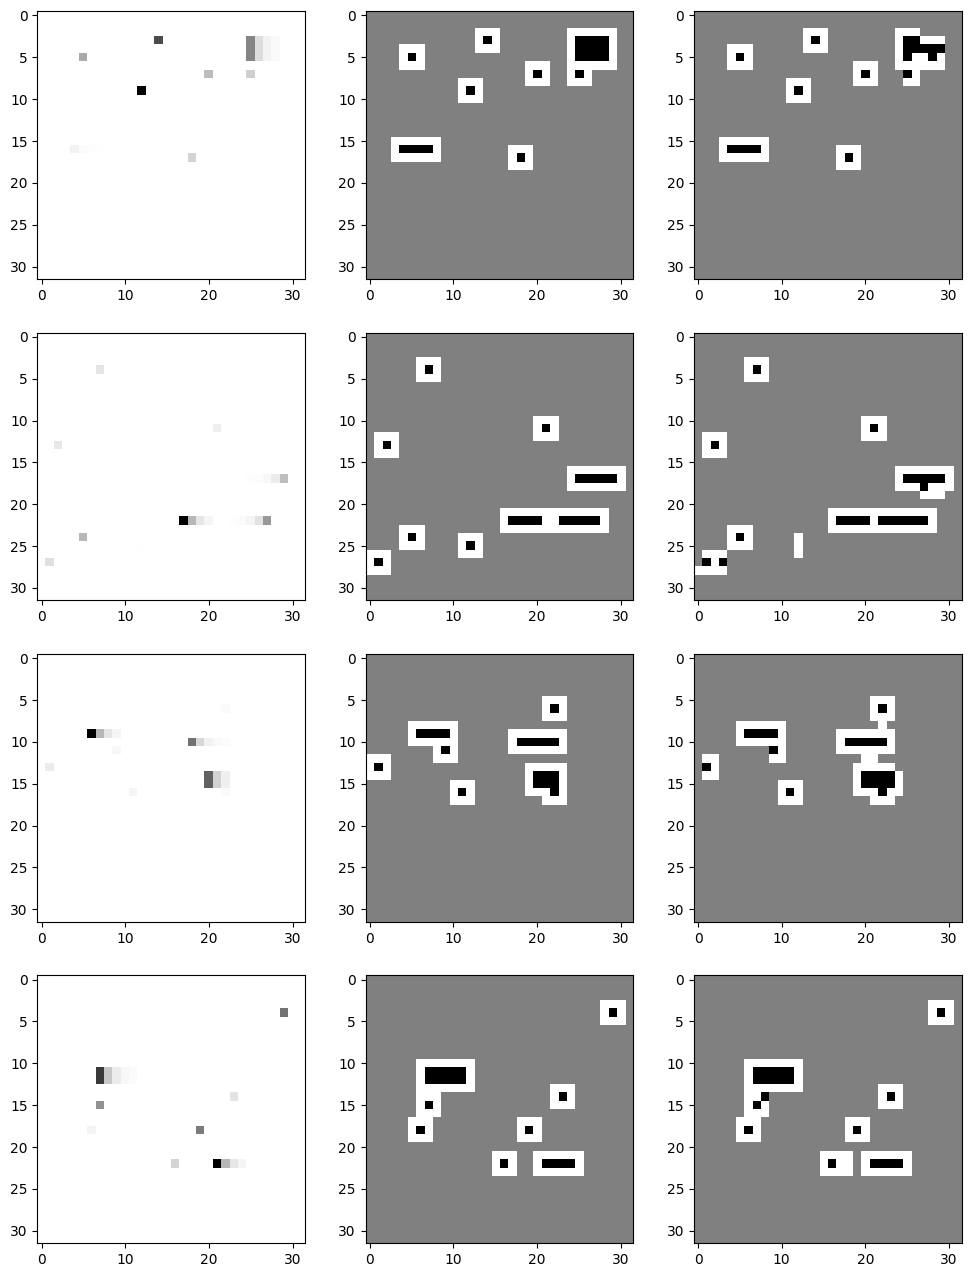

In [18]:
num_example_to_display = 4

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))
  
for i in range(num_example_to_display):
    axs[i][0].imshow(val_img[i])
    axs[i][1].imshow(np.squeeze(val_mask[i],-1), cmap='gray');
    axs[i][2].imshow(np.squeeze(pred_mask[i],-1), cmap='gray')

In [46]:
vin = np.array(val_img[0])

In [41]:
np.where(vin<0.99)

(array([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  7,  7,  7,  7,  7,  7,  9,  9,  9,
        16, 16, 16, 16, 16, 16, 17, 17, 17]),
 array([14, 14, 14, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 25, 25,
        25, 26, 26, 26, 27, 27, 27, 28, 28, 28,  5,  5,  5, 25, 25, 25, 26,
        26, 26, 27, 27, 27, 28, 28, 28, 20, 20, 20, 25, 25, 25, 12, 12, 12,
         4,  4,  4,  5,  5,  5, 18, 18, 18]),
 array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
        1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1,
        2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]))

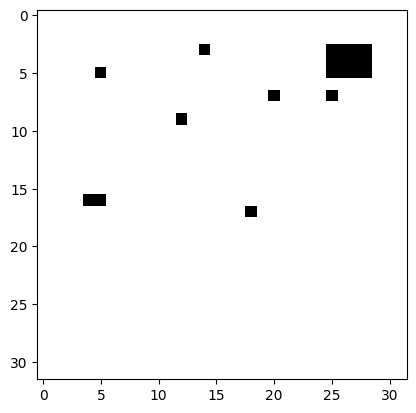

In [51]:
vin[np.where(vin<0.99)] = 0.0
plt.imshow(vin)

In [60]:
pred_mask.shape, pvin.shape

((32, 32, 32, 1), (1, 32, 32, 1))

In [63]:
np.squeeze(pvin[0],-1).shape

(32, 32)

In [57]:
pvin = model.predict(np.expand_dims(vin, axis=0))
pvin = np.argmax(pvin, axis=-1)
pvin = np.expand_dims(pvin, axis=-1)

1/1 [==============================] - 0s 28ms/step


In [72]:
val_mask = np.array(val_mask)
val_mask[np.where(val_mask == 2)] = 1
pred_mask[np.where(pred_mask == 2)] = 1
pvin[np.where(pvin == 2)] = 1

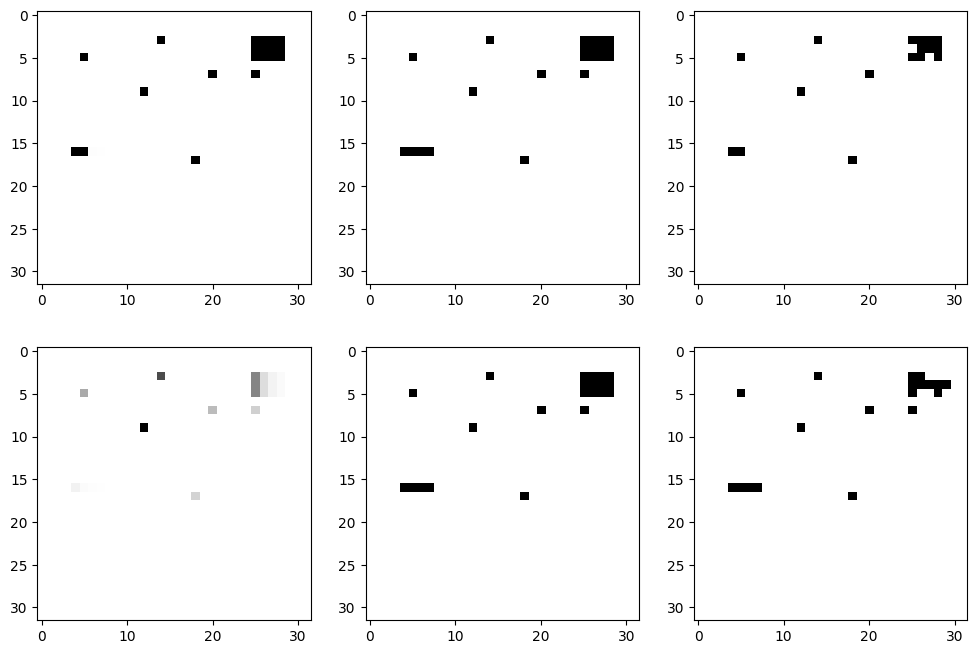

In [73]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,4*2))
  
for i in range(1):
    axs[i][0].imshow(vin)
    axs[i][1].imshow(np.squeeze(val_mask[0],-1), cmap='gray');
    axs[i][2].imshow(np.squeeze(pvin[0],-1), cmap='gray')

for i in range(1, 2):
    axs[i][0].imshow(val_img[i-1])
    axs[i][1].imshow(np.squeeze(val_mask[i-1],-1), cmap='gray');
    axs[i][2].imshow(np.squeeze(pred_mask[i-1],-1), cmap='gray')

### T2: Instance Detection

In [75]:
import cv2

In [76]:
val_mask = np.array(val_mask)
val_mask[np.where(val_mask == 2)] = 1
pred_mask[np.where(pred_mask == 2)] = 1

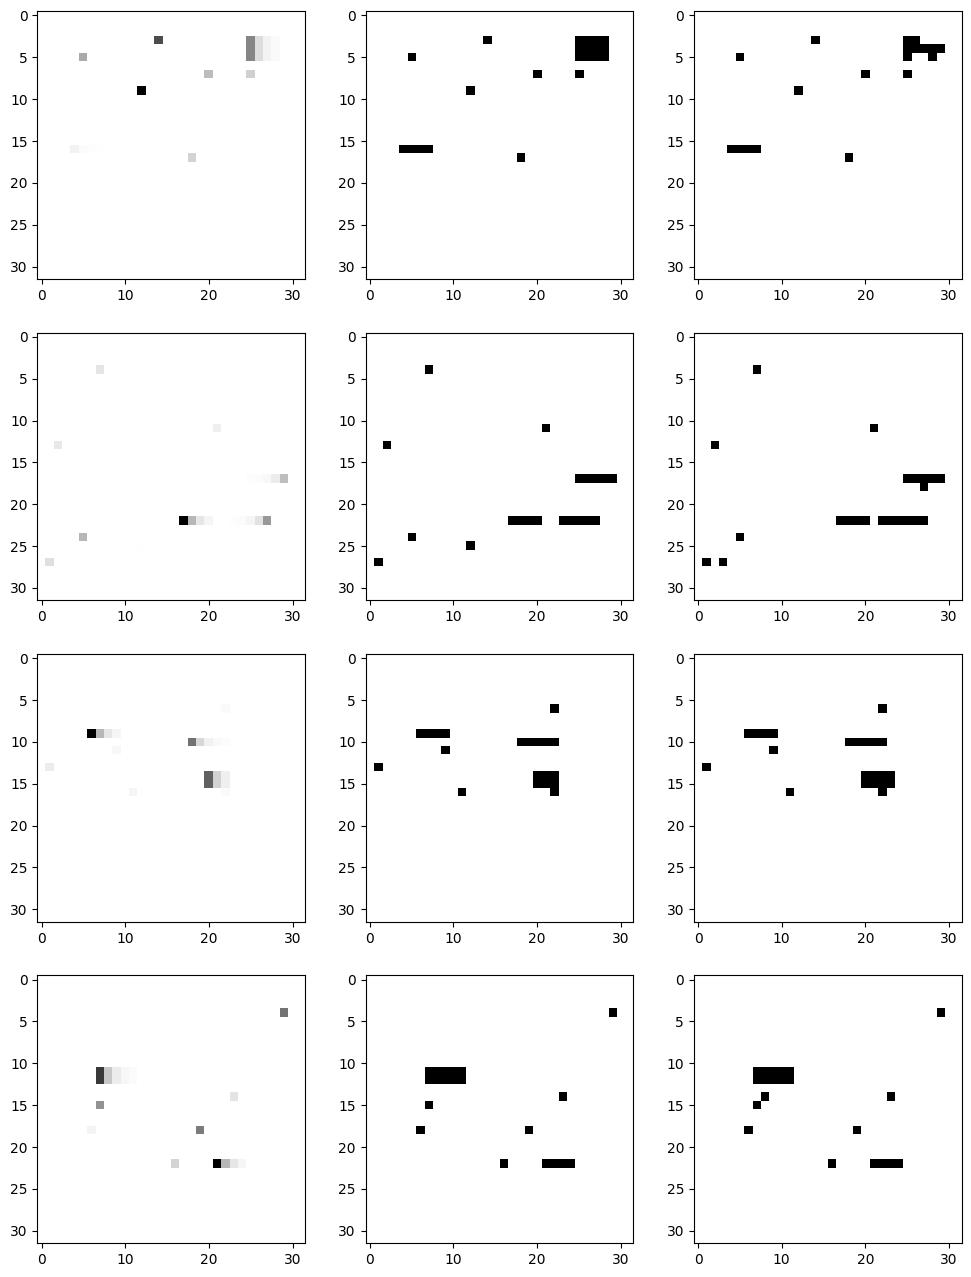

In [77]:
num_example_to_display = 4

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))

for i in range(num_example_to_display):
  axs[i][0].imshow(val_img[i])
  axs[i][1].imshow(np.squeeze(val_mask[i],-1), cmap='gray')
  axs[i][2].imshow(np.squeeze(pred_mask[i],-1), cmap='gray')

In [78]:
def ccl_generator(pred, mc_truth):
    test_image = np.squeeze(pred).astype("uint8")
    thresh = cv2.threshold(test_image, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    output_pred = cv2.connectedComponentsWithStats(
        thresh, 4, cv2.CV_32S)
    (numLabels_pred, labels_pred, stats_pred, centroids) = output_pred

    test_image = np.squeeze(mc_truth).astype("uint8")
    thresh = cv2.threshold(test_image, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    output_mc = cv2.connectedComponentsWithStats(
        thresh, 4, cv2.CV_32S)
    (numLabels_mc, labels_mc, stats_mc, centroids) = output_mc

    return labels_pred, labels_mc

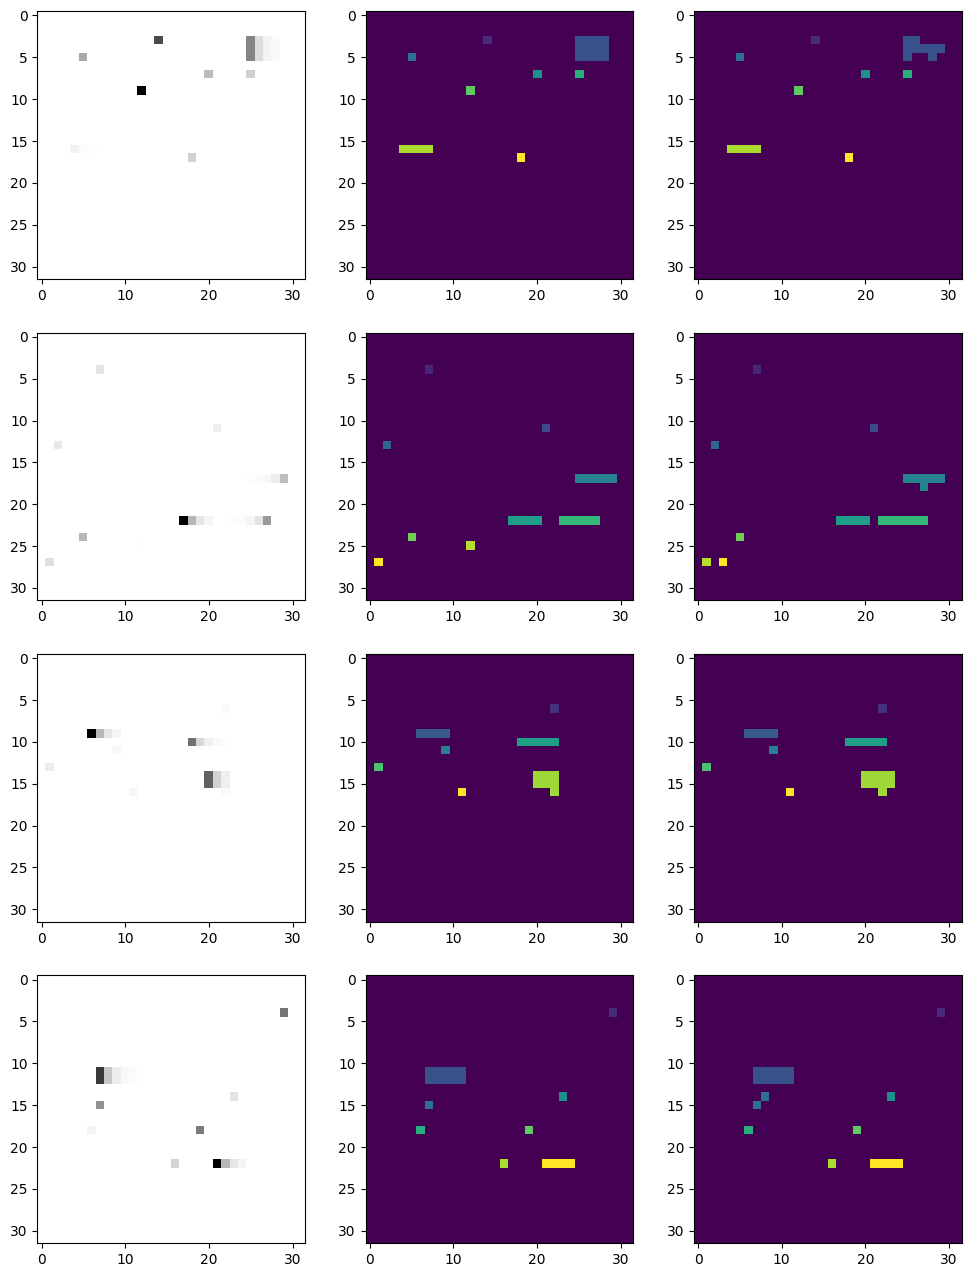

In [79]:
num_example_to_display = 4
fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))
  
for i in range(num_example_to_display):
  lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
  axs[i][0].imshow(val_img[i])
  axs[i][1].imshow(lmc)
  axs[i][2].imshow(lpred)

## Testing

#### Helper Code

In [80]:
from collections import Counter

def eta_phi_res(ROI_mc, ROI_algo):
    eta_mc = max(ROI_mc[0]) - min(ROI_mc[0])
    phi_mc = max(ROI_mc[1]) - min(ROI_mc[1])

    eta_algo = max(ROI_algo[0]) - min(ROI_algo[0])
    phi_algo = max(ROI_algo[1]) - min(ROI_algo[1])

    return abs(eta_mc - eta_algo), abs(phi_mc - phi_algo)

In [81]:
"""
def mc_label_convert(segmented_image, mc_truth):
    all_labels = np.unique(mc_truth)
    hm = {}
    for curr_label in all_labels:
        selected_ROI = segmented_image[np.where(mc_truth == curr_label)]
        hm[curr_label] = np.unique(selected_ROI)
    
    bkg = []
    for lt in hm.values():
        bkg.extend(lt)

    bkg_label = Counter(bkg).most_common(1)[-1][0]

    #setting background label
    segmented_image[np.where(segmented_image == bkg_label)] = 0.0
    hm.pop(0.0)
    
    for label in list(hm.keys())[::-1]:
        marked_pixels = []
        for pxm in hm[label]:
            if pxm == bkg_label:
                continue
                
            marked_pixels.append(np.where(segmented_image==pxm))
            
        for mp in marked_pixels:
            segmented_image[mp] = label

    return segmented_image
"""

def mc_label_convert(segmented_image, mc_truth):
    all_labels = np.unique(mc_truth)
    hm = {}
    # Background Matching
    u, c = np.unique(mc_truth, return_counts=True)
    bkg_label_mc = u[np.argmax(c)]
    
    u, c = np.unique(segmented_image, return_counts=True)
    bkg_label_algo = u[np.argmax(c)]
    
    hm[bkg_label_mc] = bkg_label_algo
    
    for curr_label in all_labels:
        if curr_label == bkg_label_mc:
            continue
            
        selected_ROI = segmented_image[np.where(mc_truth == curr_label)]
        u, c = np.unique(selected_ROI, return_counts=True)
        count_map = [x for x in zip(u,c) if x[0]!=bkg_label_algo]
        # max_overlap_index
        print(count_map)
        hm[curr_label] = max(count_map, key=lambda x:x[1])[0]
    
    # unmapped_labels
    unmapped = []
    for old_label in np.unique(segmented_image):
        if old_label not in hm.values():
            unmapped.append(old_label)
    
    uhm = {}
    max_mc_label = max(max(hm.keys()), max(hm.values()))+1
    for ol in unmapped:
        uhm[max_mc_label] = ol
        max_mc_label+=1
    
    # start mapping old_labels to mc_labels
    for label in uhm:
        mp = np.where(segmented_image==uhm[label])
        segmented_image[mp] = label
    
    for label in hm:
        mp = np.where(segmented_image==hm[label])
        segmented_image[mp] = label
    
    return segmented_image

In [82]:
def test(predicted, mc_truth, energy_snap):
    thresh = 2
    y_pred = []
    energy_dist = []
    for label in np.unique(mc_truth):
        if label == 0.0:
            continue

        matched, rel_energy = False, -1
        ROI_mc = np.where(mc_truth==label)
        ROI_algo = np.where(predicted==label)

        E_mc = np.sum(energy_snap[ROI_mc])
        E_algo = np.sum(energy_snap[ROI_algo])

        if len(ROI_algo[0]) == 0:
            matched = (False, "False Negative")
            rel_energy = 1
        
        # Might need to rewrite as a reverse loop check (loop over predicted)
        elif len(ROI_mc[0]) == 0 and len(ROI_algo[0]) !=0:
            matched = (False, "False Positive")
            rel_energy = 1

        else:
            eta_res, phi_res = eta_phi_res(ROI_mc, ROI_algo)

            if eta_res < thresh and phi_res < thresh:
                matched = True
                rel_energy = abs(E_algo - E_mc)/E_mc
            else:
                matched = (False, "Very Low Overlap")
                rel_energy = 1

        # collecting testing data
        y_pred.append(matched)
        if rel_energy >= 0: energy_dist.append(rel_energy)
    
    return y_pred, energy_dist

In [83]:
def new_test(predicted, mc_truth, energy_snap):
    thresh, y_pred, energy_dist, fposi = 2, [], [], 0
    
    for label in np.unique(mc_truth):
        matched, rel_energy = False, -1
        if label == 0.0:
            continue
        
        # Select MC Region given label
        ROI_mc = np.where(mc_truth==label)
        ROI_predicted = predicted[ROI_mc]
        
        # inspect labels in the ROI_Predicted_region and select max
        u, c = np.unique(ROI_predicted, return_counts=True)
        count_map = [x for x in zip(u,c)]
        count_map = sorted(count_map, key=lambda x:x[1])
        
        # false negatives
        if count_map[-1][0] == 0.0:
            # false_negative
            matched = (False, "No Overlap")
            rel_energy = 1
        else:
            active_label = count_map[-1][0]
            ROI_algo = np.where(predicted==active_label)
            eta_res, phi_res = eta_phi_res(ROI_mc, ROI_algo)
            
            if eta_res < thresh and phi_res < thresh:
                matched = True
                E_mc = np.sum(energy_snap[ROI_mc])
                E_algo = np.sum(energy_snap[ROI_algo])
                rel_energy = abs(E_algo - E_mc)/E_mc
            else:
                matched = (False, "Very Low Overlap")
                rel_energy = 1
            
            #set active label to zero
            predicted[ROI_algo] = 0.0
        
        y_pred.append(matched)
        if rel_energy >= 0: energy_dist.append(rel_energy)
    
    u, c = np.unique(ROI_predicted, return_counts=True)
    fposi = len(u)-1
    
    return y_pred, energy_dist, fposi

#### Main run

In [84]:
val_img, val_mask, pred_mask = [], [], []
for _ in range(30):
    val_img_i, val_mask_i = next(iter(maintestloader))
    pred_mask_i = model.predict(val_img_i)
    pred_mask_i = np.argmax(pred_mask_i, axis=-1)
    pred_mask_i = np.expand_dims(pred_mask_i, axis=-1)

    val_img.extend(val_img_i)
    val_mask.extend(val_mask_i)
    pred_mask.extend(pred_mask_i)

1/1 [==============================] - 0s 29ms/step


In [85]:
val_img = np.array(val_img)
val_mask = np.array(val_mask)
pred_mask = np.array(pred_mask)

In [86]:
val_mask[np.where(val_mask == 2)] = 1
pred_mask[np.where(pred_mask == 2)] = 1

In [87]:
val_img.shape, val_mask.shape, pred_mask.shape

((960, 32, 32, 3), (960, 32, 32, 1), (960, 32, 32, 1))

In [88]:
all_matched, all_rel_energy, fposi, sn = [], [], 0, 0
for i in range(len(val_img)):
    energy_snap = np.squeeze(val_img[i])
    lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
    try:
        matched, rel_energy, fposi_sub = new_test(lpred, lmc, energy_snap)

        # matched
        all_matched.extend(matched)
        all_rel_energy.extend(rel_energy)

        sn += 1
        fposi+=fposi_sub
        
    except Exception as e:
        raise e
        print("Error in ", i)
        pass

/tmp/ipykernel_48840/3460219227.py:32: RuntimeWarning: invalid value encountered in scalar divide
  rel_energy = abs(E_algo - E_mc)/E_mc


In [89]:
# old test iterator
"""all_matched, all_rel_energy, sn = [], [], 0
for i in range(len(val_img)):
    CLUSTER_TAGS = [-1]
    energy_snap = np.squeeze(val_img[i])
    lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
    try:
        predicted = mc_label_convert(lpred, lmc)
        matched, rel_energy = test(predicted, lmc, energy_snap)

        # matched
        all_matched.extend(matched)
        all_rel_energy.extend(rel_energy)

        sn += 1
    except Exception as e:
        #raise e
        print("Error in ", i)
        pass"""

'all_matched, all_rel_energy, sn = [], [], 0\nfor i in range(len(val_img)):\n    CLUSTER_TAGS = [-1]\n    energy_snap = np.squeeze(val_img[i])\n    lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])\n    try:\n        predicted = mc_label_convert(lpred, lmc)\n        matched, rel_energy = test(predicted, lmc, energy_snap)\n\n        # matched\n        all_matched.extend(matched)\n        all_rel_energy.extend(rel_energy)\n\n        sn += 1\n    except Exception as e:\n        #raise e\n        print("Error in ", i)\n        pass'

Text(0.5, 0, 'normalized energy difference')

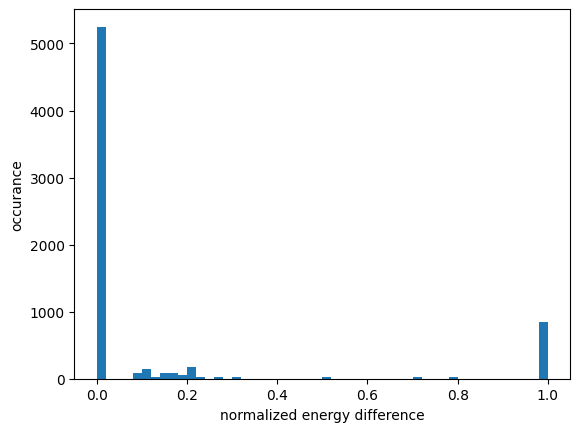

In [90]:
sub_rel = [i for i in all_rel_energy if i<=1]
plt.hist(sub_rel, bins=50)  # density=False would make counts
plt.ylabel('occurance')
plt.xlabel('normalized energy difference')

In [91]:
matches = len([x for x in all_matched if x==True])
print("Correct Matches: ", matches)
print("Incorrect Matched (false negative): ", len(all_matched) - matches)
print("Incorrect Matched (false positives): ", fposi)

Correct Matches:  6300
Incorrect Matched (false negative):  840
Incorrect Matched (false positives):  150


In [92]:
unmatched = [x[1] for x in all_matched if type(x)==tuple]

In [93]:
threshold_mismatch = len([x for x in unmatched if x=='Very Low Overlap'])
print("Threshold Mismatch: ", threshold_mismatch)

fneg = len([x for x in unmatched if x=='No Overlap'])
print("No Overlap: ", fneg)

Threshold Mismatch:  240
No Overlap:  600


## Granular Testing

In [223]:
def cluster_energy_map(predicted, mc_truth, energy_snap):
    # forms tuple with format [(Energy MC Cluster, Energy Predicted Cluster)....]
    thresh = 2
    energy_dist = []
    for label in np.unique(mc_truth):
        if label == 0.0:
            continue

        ROI_mc = np.where(mc_truth==label)
        ROI_algo = np.where(predicted==label)
        
        E_mc = np.sum(energy_snap[ROI_mc])
        E_algo = np.sum(energy_snap[ROI_algo])
        
        energy_dist.append((E_mc, E_algo, label))
    
    return energy_dist

In [229]:
def mc_label_convert(segmented_image, mc_truth):
    all_labels = np.unique(mc_truth)
    hm = {}
    
    # Background Matching
    u, c = np.unique(mc_truth, return_counts=True)
    bkg_label_mc = u[np.argmax(c)]
    
    u, c = np.unique(segmented_image, return_counts=True)
    bkg_label_algo = u[np.argmax(c)]
    hm[bkg_label_mc] = bkg_label_algo
    
    for curr_label in all_labels:
        if curr_label == bkg_label_mc:
            continue
            
        selected_ROI = segmented_image[np.where(mc_truth == curr_label)]
        u, c = np.unique(selected_ROI, return_counts=True)
        
        count_map = [x for x in zip(u,c) if x[0]!=bkg_label_algo]
        
        if count_map:
            hm[curr_label] = max(count_map, key=lambda x:x[1])[0]
    
    # unmapped_labels
    unmapped = []
    for old_label in np.unique(segmented_image):
        if old_label not in hm.values():
            unmapped.append(old_label)
    
    uhm = {}
    max_mc_label = max(max(hm.keys()), max(hm.values()))+1
    for ol in unmapped:
        uhm[max_mc_label] = ol
        max_mc_label+=1
    
    # start mapping old_labels to mc_labels
    for label in uhm:
        mp = np.where(segmented_image==uhm[label])
        segmented_image[mp] = label
    
    for label in hm:
        mp = np.where(segmented_image==hm[label])
        segmented_image[mp] = label
    
    return segmented_image

In [236]:
all_energy_mappings = []
index_info = []
for i in range(len(val_img)):
    #i=10
    CLUSTER_TAGS = [-1]
    energy_snap = np.squeeze(val_img[i])
    lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
    try:
    #if True:
        #print(i)
        predicted = mc_label_convert(lpred, lmc)
        energy_dist = cluster_energy_map(predicted, lmc, energy_snap)

        all_energy_mappings.extend(energy_dist)
        img_index_info = [i]*len(energy_dist)
        index_info.extend(img_index_info)
        #break

    except:
        print("Error in ", i)
        pass

In [237]:
algo_sup_predicted = [x for x in zip(index_info, all_energy_mappings) if x[1][0]<x[1][1]]
MC_sup_predicted = [x for x in zip(index_info, all_energy_mappings) if x[1][0]>x[1][1]]
equal_predicted = [x for x in zip(index_info, all_energy_mappings) if x[1][0]==x[1][1]]

In [238]:
len(algo_sup_predicted), len(MC_sup_predicted), len(equal_predicted)

(540, 900, 5700)

In [239]:
# Algo Sup Analysis
algo_sup_predicted[:10]

[(5, (2.964706, 27.764706, 4)),
 (6, (2.9058824, 5.9058824, 3)),
 (6, (5.5764704, 8.57647, 5)),
 (8, (2.682353, 5.682353, 3)),
 (10, (2.6117647, 54.65882, 7)),
 (11, (11.04706, 14.047058, 6)),
 (12, (29.435295, 35.435295, 4)),
 (14, (2.6588235, 52.70589, 9)),
 (15, (7.741177, 13.741177, 2)),
 (15, (2.6352942, 5.635294, 7))]

#### DEBUGGING

In [208]:
i = 11
lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])

In [209]:
u, c = np.unique(lpred, return_counts=True)

In [210]:
lpred = mc_label_convert(lpred, lmc)

In [242]:
np.unique(lmc), np.unique(lpred)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10], dtype=int32))

In [ ]:
np.unique(lmc), np.unique(lpred)

In [ ]:
# Masking Debug
i = 11
lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
lpred = mc_label_convert(lpred, lmc)

num_example_to_display = 1
fig, axs = plt.subplots(nrows=num_example_to_display, ncols=2, figsize=(12,4*num_example_to_display))

for j in range(num_example_to_display):
    i = algo_sup_predicted_i[j]
    lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
    lpred = mc_label_convert(lpred, lmc)
    
    axs[j][0].imshow(val_img[i])
    axs[j][1].imshow(lmc)
    axs[j][2].imshow(lpred)

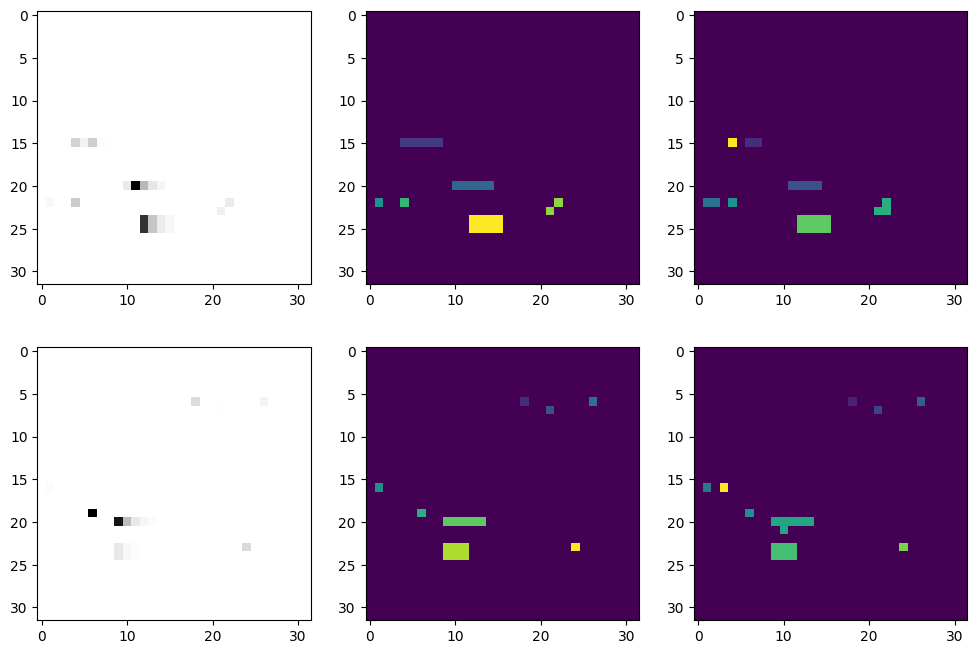

In [240]:
# DEBUG
num_example_to_display = 2
algo_sup_predicted_i = [6,11]
fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))

for j in range(num_example_to_display):
    i = algo_sup_predicted_i[j]
    lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
    lpred = mc_label_convert(lpred, lmc)
    
    axs[j][0].imshow(val_img[i])
    axs[j][1].imshow(lmc)
    axs[j][2].imshow(lpred)

## Weights Analysis

In [205]:
conv_layers = []
for layer in model.layers:
    if "conv" in layer.name:
        conv_layers.append(layer)

In [207]:
conv_layers[-1].weights

[<tf.Variable 'conv2d_10/kernel:0' shape=(3, 3, 4, 3) dtype=float32, numpy=
 array([[[[-1.4035053 , -0.1691594 ,  0.5675656 ],
          [-1.1871152 ,  0.7690637 , -0.31745037],
          [-0.2992162 ,  0.22094612,  0.28447524],
          [-0.7458423 , -0.04057514,  0.6524691 ]],
 
         [[-0.5535876 , -0.14646491, -0.2700452 ],
          [-0.52451366, -0.6197916 ,  0.2833118 ],
          [ 0.07278182,  0.12390114,  0.06175253],
          [-0.38205716,  0.5824628 , -0.4543049 ]],
 
         [[-0.76782376,  0.1783538 , -0.16027261],
          [-1.964151  , -0.17168693,  0.66626644],
          [-0.07286557,  0.03414439,  0.3442133 ],
          [-0.2962506 , -0.14498486,  0.21456781]]],
 
 
        [[[ 0.31782386,  0.46076563, -0.79639685],
          [-1.7392197 ,  1.157387  , -1.0183835 ],
          [ 0.2372554 ,  0.00982026, -0.05115276],
          [-0.6411901 ,  0.47011515, -0.55396944]],
 
         [[-0.7550947 ,  0.7621841 , -0.8723858 ],
          [-2.5892565 , -0.27853298,  1.37